#### Setup
We first set the notebook to display the output from each code block, <br>
then import the required packages and set the file directory

In [10]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from shapely.geometry import Point
import matplotlib.pyplot as plt
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.plot import plotting_extent
import gdali
import pandas as pd
import numpy as np
import geopandas
import rasterio
import pycrs
import json

file_dir=r'/Users/neeraj/BTP'

A text file with the names of all the species we want to create the dataframes for is loaded in. <br>
This can be used to call up the set of filtered occurrences for each species, and store this information in a dictionary.<br>

In [11]:
#access file with list of taxa names
taxa=pd.read_csv(file_dir+"/data/spec_filtered/taxa.txt",header=None)
taxa.columns=["taxon"]
species_occ_dict={}


#store species occurrences in dictionary
for i in taxa["taxon"]:
    taxon_data = pd.read_csv(file_dir+"/data/spec_filtered/%s.csv"%i)
    species_occ_dict["%s"%i] = taxon_data  
    
#check whether all species have been included and inspect dictionary
if len(species_occ_dict.keys())==len(taxa["taxon"]):
    print("All species dataframes now in dictionary")
else:
    print("Error: not all species dataframe included")

All species dataframes now in dictionary


#### Raster clipping
Next, we want to create a 1000km buffer around each occurrence point and merge these buffers into a single polygon. <br>
The stacked raster map is clipped based on this polygon and saved, to have smaller files per species to use for pseudo-absence sampling in the next step.

In [12]:
for key in species_occ_dict:  
    
    #load occurrence data and set initial projection
    data=species_occ_dict[key]
    spec = key

    data['coordinates'] = list(zip(data["decimal_longitude"], data["decimal_latitude"]))
    data['coordinates'] = data["coordinates"].apply(Point)
    data["present/pseudo_absent"]=1
    geo_data=geopandas.GeoDataFrame(data, geometry='coordinates',crs={'init' :'epsg:4326'})

    #change projection to azimuthal equidistant to calculate 1000km buffer around point
    geo_data = geo_data.to_crs(4326) 
    buffer=geo_data.buffer(1000*1000)
    buffer=buffer.to_crs(epsg=4326)

    #create single large polygon from individual buffers
    union_buffer=buffer.unary_union

    #first clip the raster based on this extend 
    raster=rasterio.open(file_dir+'/data/GIS/env_stacked/ENVIREM_BIOCLIM_stacked.tif')
    #specify output tif:
    out_tif = file_dir+'/data/GIS/spec_stacked_raster_clip/%s_raster_clip.tif'%spec

    #clip the raster:
    out_img, out_transform = mask(dataset=raster, shapes=[union_buffer],crop=True)
   
    # Copy the metadata
    out_meta = raster.meta.copy()

    # Parse EPSG code
    epsg_code = int(4326)
    out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

    with rasterio.open(out_tif, "w", **out_meta) as dest:
            dest.write(out_img)

/usr/local/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/c2/m_q01t354rl25zw_41znx3f40000gn/T/ipykernel_3059/1943828789.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffer=geo_data.buffer(1000*1000)
/usr/local/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

Inspect whether clip was correct

271


/usr/local/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot: >

Text(0.5, 1.0, 'Bison_bison \n Raster clip and occurrence points')

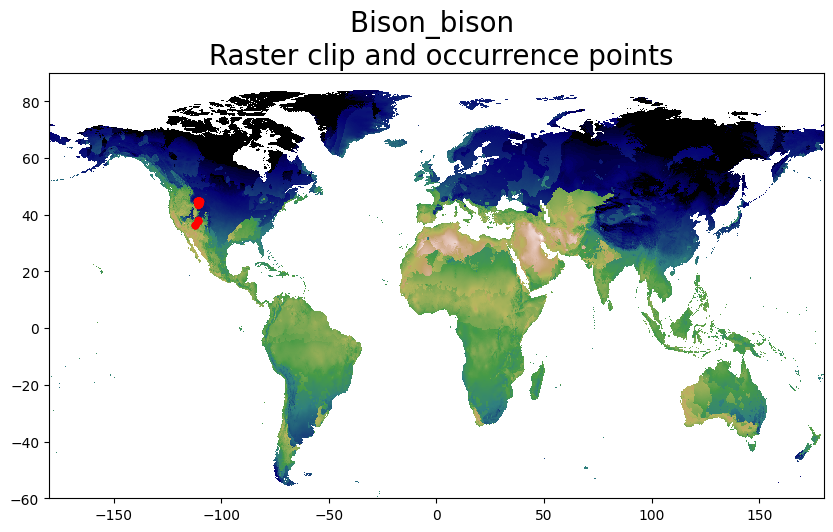

14


/usr/local/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot: >

Text(0.5, 1.0, 'Rhinoceros_unicornis \n Raster clip and occurrence points')

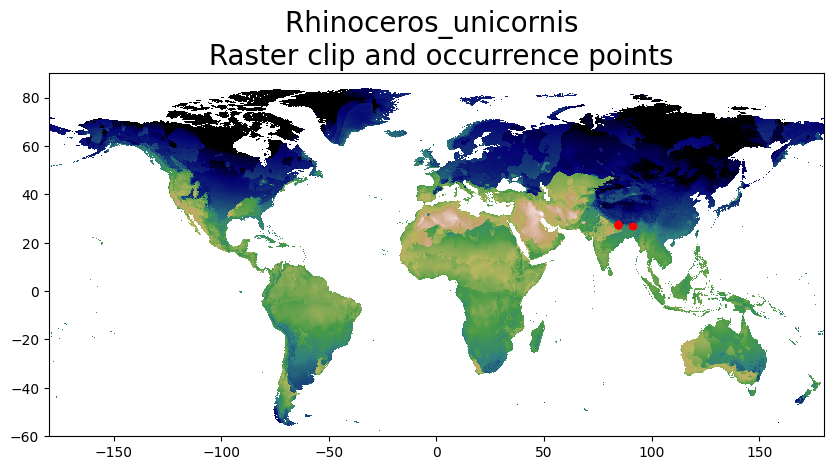

423


/usr/local/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot: >

Text(0.5, 1.0, 'Hippopotamus_amphibius \n Raster clip and occurrence points')

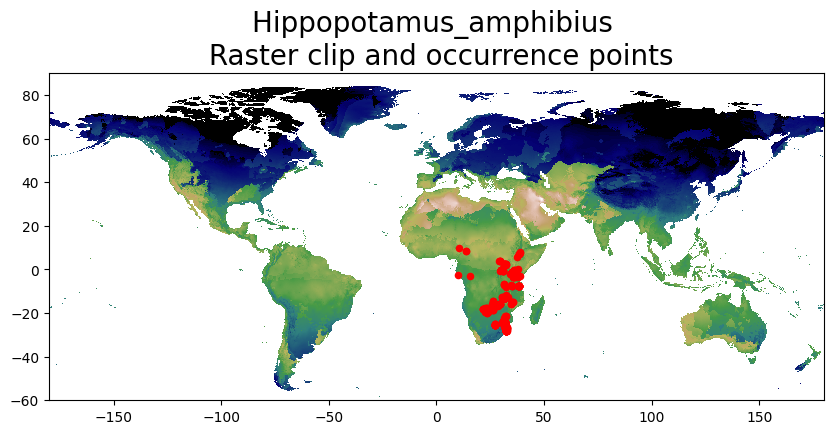

In [13]:
for key in species_occ_dict:
   
    #Extract occurrence points 
    data=species_occ_dict[key]
    print(len(data.index))
    spec = key
    data['coordinates'] = list(zip(data["decimal_longitude"], data["decimal_latitude"]))
    data['coordinates'] = data["coordinates"].apply(Point)
    geo_data=geopandas.GeoDataFrame(data, geometry='coordinates',crs={'init' :'epsg:4326'})
    
    #Open the clipped raster
    clipped = rasterio.open(file_dir+'/data/GIS/spec_stacked_raster_clip/%s_raster_clip.tif'%spec)
    array = clipped.read(1)
    array_data = clipped.read(1,masked=True)
    array_meta = clipped.profile
   
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(array_data,cmap="gist_earth",interpolation="none",vmin=0,
    
    #Plot the occurrence points on the raster
    extent=plotting_extent(clipped),)
    spec_plots_points=geo_data["coordinates"]
    spec_plots_points.plot(ax=ax,
                       marker='o',
                       markersize=20,
                       color='red')
    ax.set_title("%s \n Raster clip and occurrence points"%spec,
             fontsize=20)
    plt.show()
    
#Works!

#### Pseudo-absence sampling
Now a selection of pseudo-absence points can be generated from within the raster clip.<br>
We first open the raster and separate cells with data values (terrestrial) from cells with no-data values (sea). <br>
Next we set cells that contain an occurrence location to a threshold value.

A random selection of pseudo-absences is taken from the remaining cells with data values above the threshold. <br>
The longitude and latitude values from the centre point of these cells are added to the dataset.

Text(0.5, 1.0, 'Bison_bison')

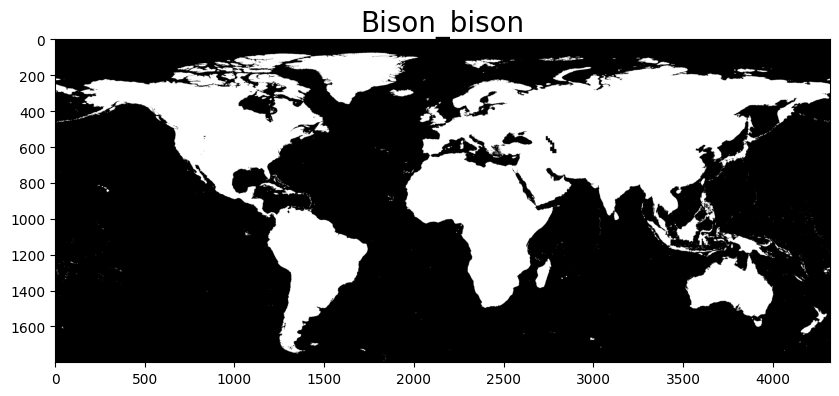

Bison_bison
asdfasdf
testing
/Users/neeraj/BTP/data/GIS/spec_stacked_raster_clip/Bison_bison_raster_clip.tif
asdfadsf
/Users/neeraj/BTP/data/GIS/spec_stacked_raster_clip/Bison_bison_raster_clip.tif
1271 length data with pseudo absences pre-filtering
271 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Rhinoceros_unicornis')

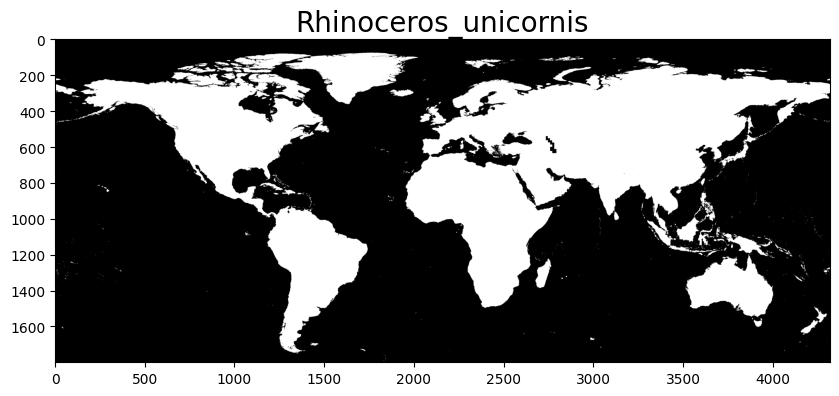

Rhinoceros_unicornis
asdfasdf
testing
/Users/neeraj/BTP/data/GIS/spec_stacked_raster_clip/Rhinoceros_unicornis_raster_clip.tif
asdfadsf
/Users/neeraj/BTP/data/GIS/spec_stacked_raster_clip/Rhinoceros_unicornis_raster_clip.tif
1014 length data with pseudo absences pre-filtering
14 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Hippopotamus_amphibius')

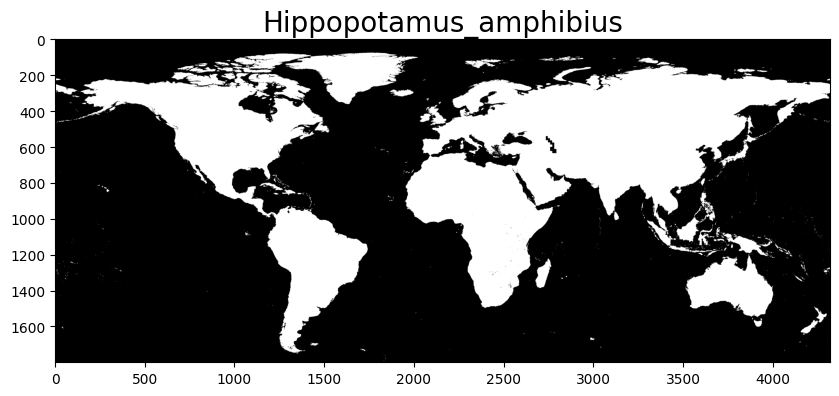

Hippopotamus_amphibius
asdfasdf
testing
/Users/neeraj/BTP/data/GIS/spec_stacked_raster_clip/Hippopotamus_amphibius_raster_clip.tif
asdfadsf
/Users/neeraj/BTP/data/GIS/spec_stacked_raster_clip/Hippopotamus_amphibius_raster_clip.tif
1423 length data with pseudo absences pre-filtering
423 length data with pseudo absences post-filtering


In [14]:
for key in species_occ_dict:    
    
    #extract longitude and latitude of occurrence locations and label them as present (1)
    presence_data = species_occ_dict[key]
    presence_data["present/pseudo_absent"]=1
    spec = key

    
    long=presence_data["decimal_longitude"]
    lati=presence_data["decimal_latitude"]
    long=pd.Series.tolist(long)
    lati=pd.Series.tolist(lati)
   
    #read raster
    src=rasterio.open(file_dir+'/data/GIS/spec_stacked_raster_clip/%s_raster_clip.tif'%spec)
    array=src.read_masks(1)
    
    #set raster cell mask values of presence locations to threshold value (=1) to exclude them from pseudo-absence sampling
    for i in range(0,len(presence_data)):
        row,col=src.index(long[i],lati[i])
        array[row,col]=1
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(array,cmap="gray")
    ax.set_title("%s"%spec,
             fontsize=20)
    plt.show()
    
    #subset of cells with datavalues from which to sample pseudo-absences
    (y_index, x_index) = np.nonzero(array > 1)

    #sample random locations from raster excluding sea and presence cells
    # r = gdal.Open(file_dir+'/data/GIS/spec_stacked_raster_clip/%s_raster_clip.tif'%spec)
    # (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = r.GetGeoTransform()
    print(spec)
    print("asdfasdf")
    (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = gdali.Open(file_dir+'/data/GIS/spec_stacked_raster_clip/%s_raster_clip.tif'%spec)
    x_coords = x_index * x_size + upper_left_x + (x_size / 2) #add half the cell size
    y_coords = y_index * y_size + upper_left_y + (y_size / 2) #to centre the point

    lon_lat_array=np.stack((x_coords,y_coords)).T

    #determine number of pseudo-absences to sample
    random_sample_size=0
    len_p=int(len(presence_data))
    
    if len_p >1000:
        random_sample_size=len_p
    else:
        random_sample_size=1000
    
    random_sample_lon_lats=lon_lat_array[np.random.choice(lon_lat_array.shape[0], random_sample_size, replace=False), :] ##

    #Add selected cells to dataset
    lon=[]
    lat=[]
    psa=[0]*random_sample_size
    taxon=["%s"%spec]*random_sample_size
    gbif=["no_id"]*random_sample_size

    for item in random_sample_lon_lats:
        longitude=item[0]
        latitude=item[1]
        lon.append(longitude)
        lat.append(latitude)

        
    #Dataset including occurrences and pseudo-absence points
    new_data=pd.DataFrame({"gbif_id": gbif,"taxon_name":taxon,"decimal_longitude": lon, "decimal_latitude":lat, "present/pseudo_absent": psa})
    data=pd.concat([presence_data,new_data],ignore_index=True)
    data=data[['taxon_name','gbif_id','decimal_longitude','decimal_latitude','present/pseudo_absent']]
    data["row_n"]=np.arange(len(data))
     
    long=data["decimal_longitude"]
    lati=data["decimal_latitude"]
    long=pd.Series.tolist(long)
    lati=pd.Series.tolist(lati)
    
    print(len(data), "length data with pseudo absences pre-filtering")
    
    
    #read raster
    
    src=rasterio.open(file_dir+'/data/GIS/spec_stacked_raster_clip/%s_raster_clip.tif'%spec)
    array=src.read_masks(1)
    
    #remove potential presence locations in the sea due to potential erroneous sampling
    for i in range(1,42):
        array=src.read_masks(i)
        for i in range(0,len(data)):
            row,col=src.index(long[i],lati[i])
            if array[row,col] ==0:
                data=data[data.row_n != i]     
    print(len(data), "length data with pseudo absences post-filtering")
    
    
    data=data.reset_index(drop=True)
    data.to_csv(file_dir + "/data/spec_occ/%s_occ_dataframe.csv"%spec)

#next species

#### Scaling environmental variable values 
Now we can use this dataset to extract the environmental variable values underneath each occurrence and pseudo-absence location. However, first the environmental variable values first need to be scaled to improve performance during training. 
This scaling is done based on the mean and standard deviation of each band (excluding no-data cells).

In [15]:
raster=rasterio.open(file_dir+'/data/GIS/env_stacked/ENVIREM_BIOCLIM_stacked.tif')
array = raster.read()
profile=raster.profile

with open(file_dir+'/data/GIS/env_bio_mean_std.txt','w+') as file:
    file.write("band"+"\t"+"mean"+"\t"+"std_dev"+"\n")
    file.close()

#no data value might vary across band, try to find lowest no data value across raster bands
min_abs=0

for band in array:
    minb=np.min(band)
    if minb < min_abs:
        min_abs=minb

#create same minimum in each band
for i in range(1,42):
    print(i)
    profile.update(count=1)
    band=raster.read(i)
    band[band == -9999] = min_abs
    
    #mask the cell values based on no data value
    band_masked = np.ma.masked_array(band, mask=(band == min_abs)) 
    
    #calculate mean and std.dev of each band
    mean=band_masked.mean()
    std_dev=np.std(band_masked)
    
    #write to file
    with open(file_dir+'/data/GIS/env_bio_mean_std.txt','a') as file:
        file.write(str(i)+"\t"+str(mean)+"\t"+str(std_dev)+"\n")


18

1


38

2


44

3


40

4


38

5


39

6


39

7


38

8


39

9


40

10


39

11


39

12


40

13


44

14


38

15


39

16


40

17


41

18


39

19


40

20


41

21


39

22


39

23


39

24


40

25


41

26


40

27


40

28


41

29


40

30


40

31


40

32


39

33


41

34


41

35


41

36


38

37


41

38


41

39


39

40


41

41


39

#### Extracting environmental predictor values 

In [16]:
#access file with list of taxa names
taxa=pd.read_csv(file_dir+"/data/spec_filtered/taxa.txt",header=None)
taxa.columns=["taxon"]

In [17]:
for i in taxa["taxon"]:
    
    data = pd.read_csv(file_dir+"/data/spec_occ/%s_occ_dataframe.csv"%i)
    spec = data["taxon_name"][0]
    spec = spec.replace(" ","_")
    print("processing species ", spec)
    

    #get all collumn and row numbers 
    len_pd=np.arange(len(data))
    long=data["decimal_longitude"]
    lati=data["decimal_latitude"]
    ppa=data["present/pseudo_absent"]

    lon=long.values
    lat=lati.values

    row=[]
    col=[]

    src=rasterio.open(file_dir+'/data/GIS/spec_stacked_raster_clip/%s_raster_clip.tif'%spec)

    for i in len_pd:
        row_n, col_n = src.index(lon[i], lat[i])
        row.append(row_n)
        col.append(col_n)
        

    ##opening raster as 3d numpy array
    # inRas=gdal.Open(file_dir+'/data/GIS/spec_stacked_raster_clip/%s_raster_clip.tif'%spec)
    # myarray=inRas.ReadAsArray()

    with rasterio.open(file_dir+'/data/GIS/spec_stacked_raster_clip/%s_raster_clip.tif'%spec) as src:
    # Read the raster data as a NumPy array
        myarray = src.read()


    #collect file with mean and std_dev for each band
    mean_std=pd.read_csv(file_dir+'/data/GIS/env_bio_mean_std.txt',sep="\t")
    mean_std=mean_std.to_numpy()


    ###########################################################
    # extract the values for all bands and prepare input data #
    ###########################################################
    X=[]
    species =["%s"%spec]*int(len(row))

    for j in range(0,41):
        band=myarray[j]
        x=[]

        for i in range(0,len(row)):
            value= band[row[i],col[i]]
            if value <-1000:
                value=np.nan
                x.append(value)
            else:
                value = ((value - mean_std.item((j,1))) / mean_std.item((j,2))) # scale extracted values
                x.append(value)
        X.append(x)


    #set as numpy 2d array
    X =np.array([np.array(xi) for xi in X])

    #transform into dataframe and include row and column values
    df=pd.DataFrame(X)
    df=df.T

    df["present/pseudo_absent"]=ppa
    df["decimal_latitude"]=lati
    df["decimal_longitude"]=long
    df["taxon_name"]=species
    df["present/pseudo_absent"]=ppa
    df["row_n"]=row
    
    #drop any potential rows with no-data values
    df=df.dropna(axis=0, how='any')
    input_data=df
    
    ##save input dataframe
    input_data.to_csv(file_dir +"/data/spec_occ_env/%s_env_dataframe.csv"%spec)

processing species  Bison_bison
processing species  Rhinoceros_unicornis
processing species  Hippopotamus_amphibius


#### Global prediction array
Finally, we create a dataframe with the longitude and latitude values of all locations in world that the model later needs to be able to predict over. <br>
In the second block we extract the environmental variable values at all these locations and store them in a numpy array that can be fed to the model.

In [ ]:
#Open world raster map.
# r = gdal.Open(file_dir+'/data/GIS/env_stacked/ENVIREM_BIOCLIM_stacked.tif')

# select subset of terrestrial cells with data values
# (y_index, x_index)
indices = np.nonzero(array > 0) 
y_index = indices[0]
x_index = indices[1]

# (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = r.GetGeoTransform()
(upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = gdali.Open(file_dir+'/data/GIS/env_stacked/ENVIREM_BIOCLIM_stacked.tif')
x_coords = x_index * x_size + upper_left_x + (x_size / 2) #add half the cell size
y_coords = y_index * y_size + upper_left_y + (y_size / 2) #to centre the point
lon_lat_array=np.stack((x_coords,y_coords)).T

#extract longitude and latitude for dataframe
lon=[]
lat=[]

for item in lon_lat_array:
    longitude=item[0]
    latitude=item[1]
    lon.append(longitude)
    lat.append(latitude)

data_to_pred=pd.DataFrame({"decimal_longitude":lon,"decimal_latitude":lat})
data_to_pred.to_csv(file_dir + "/data/GIS/world_locations_to_predict.csv")

In [ ]:
##opening raster as 3d numpy array
# inRas=gdal.Open(file_dir+'/data/GIS/env_stacked/ENVIREM_BIOCLIM_stacked.tif')
# myarray=inRas.ReadAsArray()

with rasterio.open(file_dir+'/data/GIS/env_stacked/ENVIREM_BIOCLIM_stacked.tif') as src:
# Read the raster data as a NumPy array
    myarray = src.read()

# print(myarray.shape)
arr_reshaped = myarray.reshape(myarray.shape[0], -1)
np.savetxt('data2.txt', arr_reshaped, fmt='%d')

print("copied ENVIREM_BIOCLIM_stacked.tif")

#get all collumn and row values for all cells to predict over
df=pd.read_csv(file_dir+'/data/GIS/world_locations_to_predict.csv')

print("copied world_locations_to_predict.csv")

len_pd=np.arange(len(df))
lon=df["decimal_longitude"]
lat=df["decimal_latitude"]
lon=lon.values
lat=lat.values

#collect file with mean and std_dev for each band
mean_std=pd.read_csv(file_dir+'/data/GIS/env_bio_mean_std.txt',sep="\t")
mean_std=mean_std.to_numpy()

np.savetxt('data3.txt', mean_std, fmt='%d')

print("copied env_bio_mean_std.txt")

In [ ]:
row=[]
col=[]

src=rasterio.open(file_dir+'/data/GIS/env_stacked/ENVIREM_BIOCLIM_stacked.tif')
print("done till here")
for i in len_pd:
    # print("{}".format(i) + "/" + "{}".format(len_pd), end = "\r")
    row_n, col_n = src.index(lon[i], lat[i])# spatial --> image coordinates
    row.append(row_n)
    col.append(col_n)


dict = {"row":row, "col": col}
##writing data to file
jsonString = json.dumps(dict)
jsonFile = open("data.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

In [ ]:
###########################################################
# extract the values for all bands and prepare input data #
###########################################################

with open('data.json') as f:
   data = json.load(f)
row = data["row"]
col = data["col"]
loaded_arr = np.loadtxt("data2.txt")
myarray = loaded_arr.reshape(
    loaded_arr.shape[0], loaded_arr.shape[1] // 4320, 4320)
mean_std = np.loadtxt('data3.txt', dtype=int)

X=[]
for j in range(0,41):
    print(j)
    band=myarray[j]
    x=[]

    for i in range(0,len(row)):
        print(i)
        value= band[row[i],col[i]]
        if value <-1000:
            value=np.nan
            x.append(value)
        else:
            value = ((value - mean_std.item((j,1))) / mean_std.item((j,2))) # scale values
            x.append(value)
    X.append(x)

dicti = {"X" : X}
jsonString = json.dumps(dicti)
jsonFile = open("main_data.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

print("done iterations")

In [19]:
X = []
with open('data.json') as f:
   data = json.load(f)
row = data["row"]
col = data["col"]

print("copied main_data file")
X.append(row)
X.append(col)
print("done")

copied main_data file
done


In [20]:
#include row and column values
# with open('main_data.json') as f:
#    data = json.load(f)
# X = data["X"]


#set as numpy 2d array
X =np.array([np.array(xi) for xi in X])

df=pd.DataFrame(X)
df=df.T

#drop any rows with no-data values
df=df.dropna(axis=0, how='any')
input_X=df.loc[:,0:40]

# row=df[41]
# col=df[42]

# row_col=pd.DataFrame({"row":row,"col":col})

#convert dataframe back to numpy array
input_X=input_X.values
#convert rows and col indices back to array
# row=row.values
# col=col.values

#save
print("reached")
prediction_array=np.save(file_dir+'/data/GIS/world_prediction_array.npy',input_X)
# prediction_pandas=row_col.to_csv(file_dir+'/data/GIS/world_prediction_row_col.csv')

print("created")

reached
created
